In [ ]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [24]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/DATA/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [25]:
import random
idx = list(range(60000))
random.shuffle(idx)

In [31]:
train_index = idx[:6000]
test_index = idx[6000:7000]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


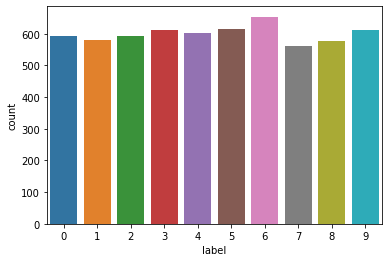

In [34]:
#train dataset으로 6000개만 사용
X_train = pd.DataFrame(data = fashion, index = train_index).drop('label', axis = 1)
y_train = pd.DataFrame(data = fashion, index = train_index)['label']
sns.countplot(y_train) #y라벨이 균등하게 분포하는지 확인
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


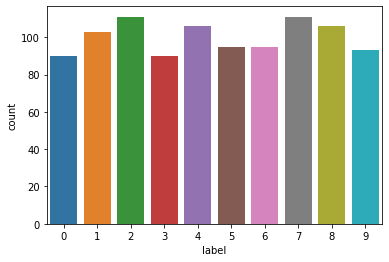

In [35]:
#test dataset으로 1000개만 사용
X_test = pd.DataFrame(data = fashion, index = test_index).drop('label', axis = 1)
y_test = pd.DataFrame(data = fashion, index = test_index)['label']
sns.countplot(y_test) #y라벨이 균등하게 분포하는지 확인
plt.show()

- 어떻게 생긴 데이터셋인지 확인해보기

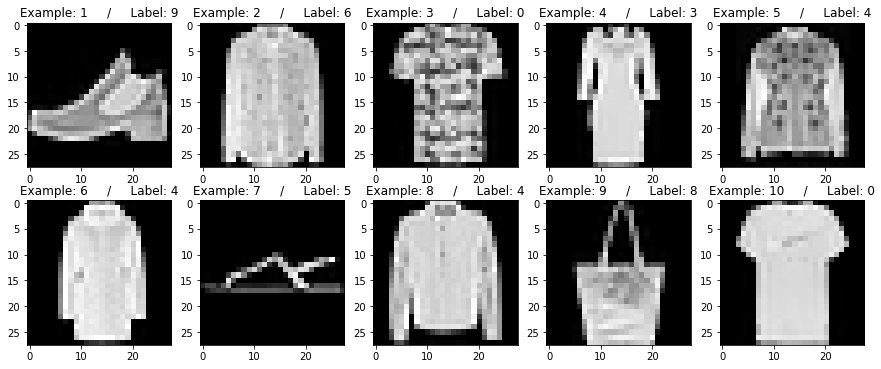

In [ ]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [36]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784) #784차원의 잠재변수
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape

(6000, 784)

In [37]:
pca.explained_variance_ratio_[:10]

array([0.28853129, 0.1769464 , 0.06134294, 0.04906266, 0.03870178,
       0.03507026, 0.02379996, 0.01915853, 0.01363679, 0.01322848])

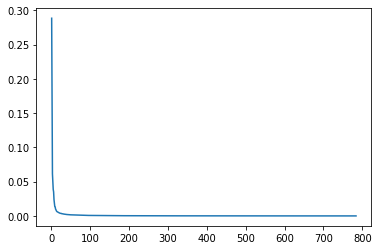

In [38]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.show()

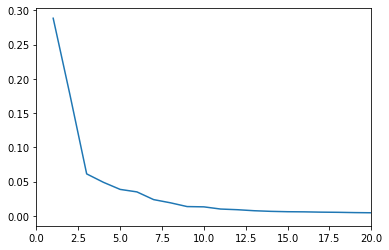

In [39]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,20)
plt.show()

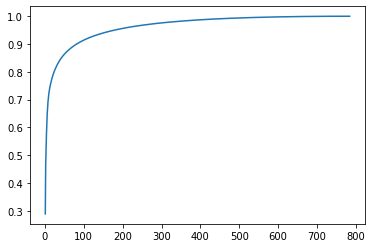

In [40]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [41]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 71.95%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.51%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.33%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.40%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [44]:
cumulative=np.array(cumulative)
np.where(cumulative>0.9)[0][0] #81개 쓰면 분산의 90%이상을 설명

81

In [45]:
cumulative=np.array(cumulative)
np.where(cumulative>0.85)[0][0] #42개 쓰면 분산의 85%이상을 설명

42

In [46]:
#pca를 통한 특징 추출 과정에서는 y라벨을 사용하지X(unsupervised)
#성능 확인 과정에서 y라벨이 사용됨
pca=PCA(n_components=42)
X_train_PCA=pca.fit_transform(X_train) #train은 fit + transform
X_test_PCA=pca.transform(X_test)       #test는 transform
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (6000, 784)
After PCA: (6000, 42)


분산 설명 비율을 5% 포인트만 줄여도 잠재변수 개수가 거의 절반으로 줄어듦. 따라서 주성분은 42개만 사용해도 충분하다고 판단, 42개 사용

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


1. 로지스틱 회귀분석

In [47]:
#차원축소 이전(origianl 공간 784차원)
start=time.time()
logistic_original=LogisticRegression(max_iter=1000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train,y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.744
52.1866sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
#차원축소 이후(42차원)
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.8431666666666666
test accuracy: 0.809
10.9323sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


로지스틱 회귀분석의 경우 차원축소시 소요시간이 20퍼센트 정도로 줄어들면서 test 정확도는 더 증가하는 모습을 보임. 

2. 랜덤포레스트

In [49]:
#차원축소 이전(784차원)
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.85
8.1551sec


In [50]:
#차원축소 이후(42차원)
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.819
4.1026sec


랜덤포레스트는 소요시간이 절반정도로 줄면서 test 정확도가 소량 감소함.

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

PCA

In [51]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

2.0263sec


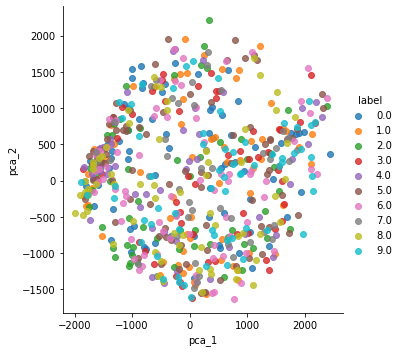

In [52]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

LDA

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

3.6928sec


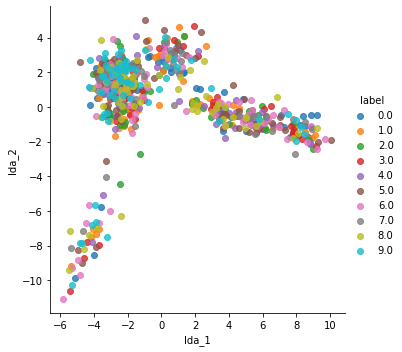

In [54]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

KPCA

In [55]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

18.2852sec


In [56]:
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

20.3875sec


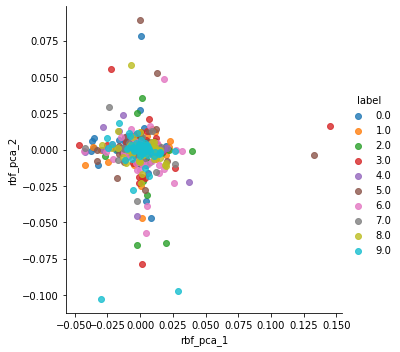

In [57]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

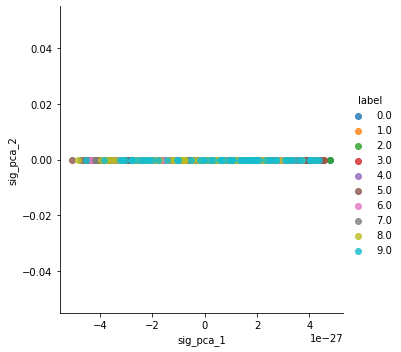

In [58]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

t-SNE

In [59]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=42) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


63.4580sec


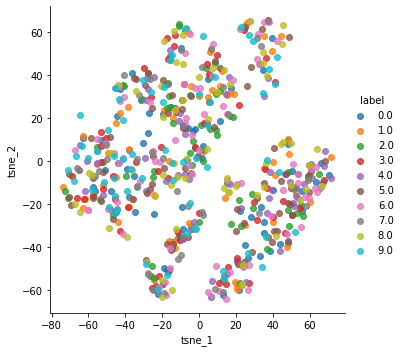

In [60]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

PCA, t-SNE 가 전반적으로 고른 그래프 모양이 보임

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

9번라벨, 아마 랜덤으로 인덱스를 추출하는 과정과 주성분을 제거하는 과정에서 9번라벨에 대한 정보가 많이 지워져서 그럴것으로 추측

수고하셨습니다~